# Bayesian Hierarchical Modeling

In [3]:
# standard imports 
import pandas as pd 
import numpy as np 

# bayesian 
import pymc as pm 

# visualizations
import seaborn as sns 
import arviz as az

# transformers 
from sklearn.preprocessing import OneHotEncoder

# pickle 
import pickle

In [63]:
# importing our data and helpful dictionaries 
gradrates_df= pd.read_csv('data/2022_NYS_grad-rate.csv',dtype={'entity_cd':'string'})
county_lookup = pd.read_pickle('county_lookup.pkl')

In [64]:
gradrates_df['county_code'] = gradrates_df['entity_cd'].str[:2]
gradrates_df['county_code'] = gradrates_df['county_code'].map(county_lookup)
gradrates_df = gradrates_df.rename(columns={'county_code':'county',
                                            'subgroup_name':'subgroup'})
gradrates_df

,entity_cd,entity_name,year,subgroup,grad_rate,county
0,010100010034,Albany High School,2022,Hispanic or Latino,73.7,Albany
1,010100010034,Albany High School,2022,White,86.9,Albany
2,010100010034,Albany High School,2022,Multiracial,77.4,Albany
3,010100010034,Albany High School,2022,English Language Learner,70.4,Albany
4,010100010034,Albany High School,2022,Economically Disadvantaged,75.5,Albany
...,...,...,...,...,...,...
4675,671501040002,Warsaw Senior High School,2022,Economically Disadvantaged,88.1,Wyoming
4676,680601060001,Penn Yan Academy,2022,White,91.1,Yates
4677,680601060001,Penn Yan Academy,2022,Economically Disadvantaged,88.6,Yates
4678,680801040001,Dundee Junior-Senior High School,2022,White,78.6,Yates


In [66]:
# transforming subgroups into binary form using pd.getdummies
subgroup_enc = pd.get_dummies(gradrates_df.subgroup)

# concatenating our two dataframes 
gradrates_df = pd.concat([gradrates_df,subgroup_enc],axis=1)

# dropping the pre-encoded subgroup column
gradrates_df = gradrates_df.drop(columns=['subgroup'])

# shifting column order for readability
gradrates_df = gradrates_df[['county','entity_name','American Indian or Alaska Native',
                             'Asian or Native Hawaiian/Other Pacific Islander','Black or African American',
                             'Economically Disadvantaged','English Language Learner','Hispanic or Latino',
                             'Multiracial','Students with Disabilities','White','grad_rate']]

In [70]:
# cleaning up our dataframe 
gradrates_df = gradrates_df.rename(columns={'entity_name':'school'})
gradrates_df.head()

,county,school,American Indian or Alaska Native,Asian or Native Hawaiian/Other Pacific Islander,Black or African American,Economically Disadvantaged,English Language Learner,Hispanic or Latino,Multiracial,Students with Disabilities,White,grad_rate
0,Albany,Albany High School,0,0,0,0,0,1,0,0,0,73.7
1,Albany,Albany High School,0,0,0,0,0,0,0,0,1,86.9
2,Albany,Albany High School,0,0,0,0,0,0,1,0,0,77.4
3,Albany,Albany High School,0,0,0,0,1,0,0,0,0,70.4
4,Albany,Albany High School,0,0,0,1,0,0,0,0,0,75.5


## Hierarchical Bayesian Modeling 

### Pooled Model 

In [71]:
counties = gradrates_df.county.unique() # list of all unique counties 
n_counties = len(counties) # int 61
county_dict = dict(zip(counties, range(n_counties)))

In [78]:
# array of len 4980 with counties encoded as integers
county = gradrates_df['county'].replace(county_dict).values 
gradrates = gradrates_df['grad_rate'] # predictor variable: float 
hisp_latx = gradrates_df['Hispanic or Latino'].values

In [109]:
coords = {'Hisp_lat':{0,1}, 'obs_id': np.arange(hisp_latx.size)}

# setting up our pooled model architecture 

with pm.Model(coords=coords) as pooled_model: 
    hislat_idx = pm.ConstantData("hislat_idx", hisp_latx, dims="obs_id")
    
    # setting up our priors
    a = pm.Normal("a", mu=0, sigma=1, dims="Hisp_lat")
    
    theta = a[hislat_idx]
    sigma = pm.HalfCauchy("sigma",1)
    
    y = pm.Normal("y", mu=theta, sigma=sigma,
                  observed=gradrates_df.grad_rate,dims="obs_id")

### Unpooled Model 

In [131]:
coords["County"] = counties
with pm.Model(coords=coords) as unpooled_model: 
    hislat_idx = pm.ConstantData("hislat_idx",hisp_latx,dims="obs_id")
    county_idx = pm.ConstantData("county_idx", county,dims="obs_id")
    a = pm.Normal("a", 0, 1, dims=("County","Hisp_lat"))
    
    theta = a[county_idx, hislat_idx]
    sigma = pm.HalfCauchy("sigma",1)

    y = pm.Normal("y",theta,sigma=sigma, 
                  observed=gradrates_df.grad_rate,dims="obs_id")

In [132]:
y

y ~ N(f(a), sigma)

### Hierarchical Model 

In [141]:
with pm.Model(coords=coords) as hierarchical_model: 
    hislat_idx = pm.ConstantData("hislat_idx",hisp_latx,dims="obs_id")
    county_idx = pm.ConstantData("county_idx", county,dims="obs_id") 
    
    #hyperpriors
    ic_mu = pm.Normal("ic_mu",mu=0, sigma=1)
    ic_sigma = pm.HalfCauchy("ic_sigma",1.0)
    
    # varying intercepts 
    county_intercept = pm.Normal("county_ic",mu=ic_mu, sigma=ic_sigma,
                                dims="County")
    # common slope beta 
    b = pm.Normal("b",mu=2, sigma=1)
    
    # expected values by county 
    theta = county_intercept[county_idx] + b * hislat_idx
    
    # model error 
    sigma = pm.HalfCauchy("sigma",1)
    
    # posterior = Normal distribution
    y = pm.Normal("y",theta, sigma=sigma, 
                  observed=gradrates_df.grad_rate,dims="obs_id")

In [143]:
with hierarchical_model:
    hierarchical_trace = pm.sample(2000, tune=2000, target_accept=0.9, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ic_mu, ic_sigma, county_ic, b, sigma]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 30 seconds.


In [145]:
with hierarchical_model:
    ppc = pm.sample_posterior_predictive(hierarchical_trace, random_seed=1055)

Sampling: [y]


C:\Users\devin\anaconda3\envs\ny-ells-project\Lib\site-packages\arviz\plots\plot_utils.py:271: UserWarning: rcParams['plot.max_subplots'] (40) is smaller than the number of variables to plot (65) in plot_posterior, generating only 40 plots
  warnings.warn(


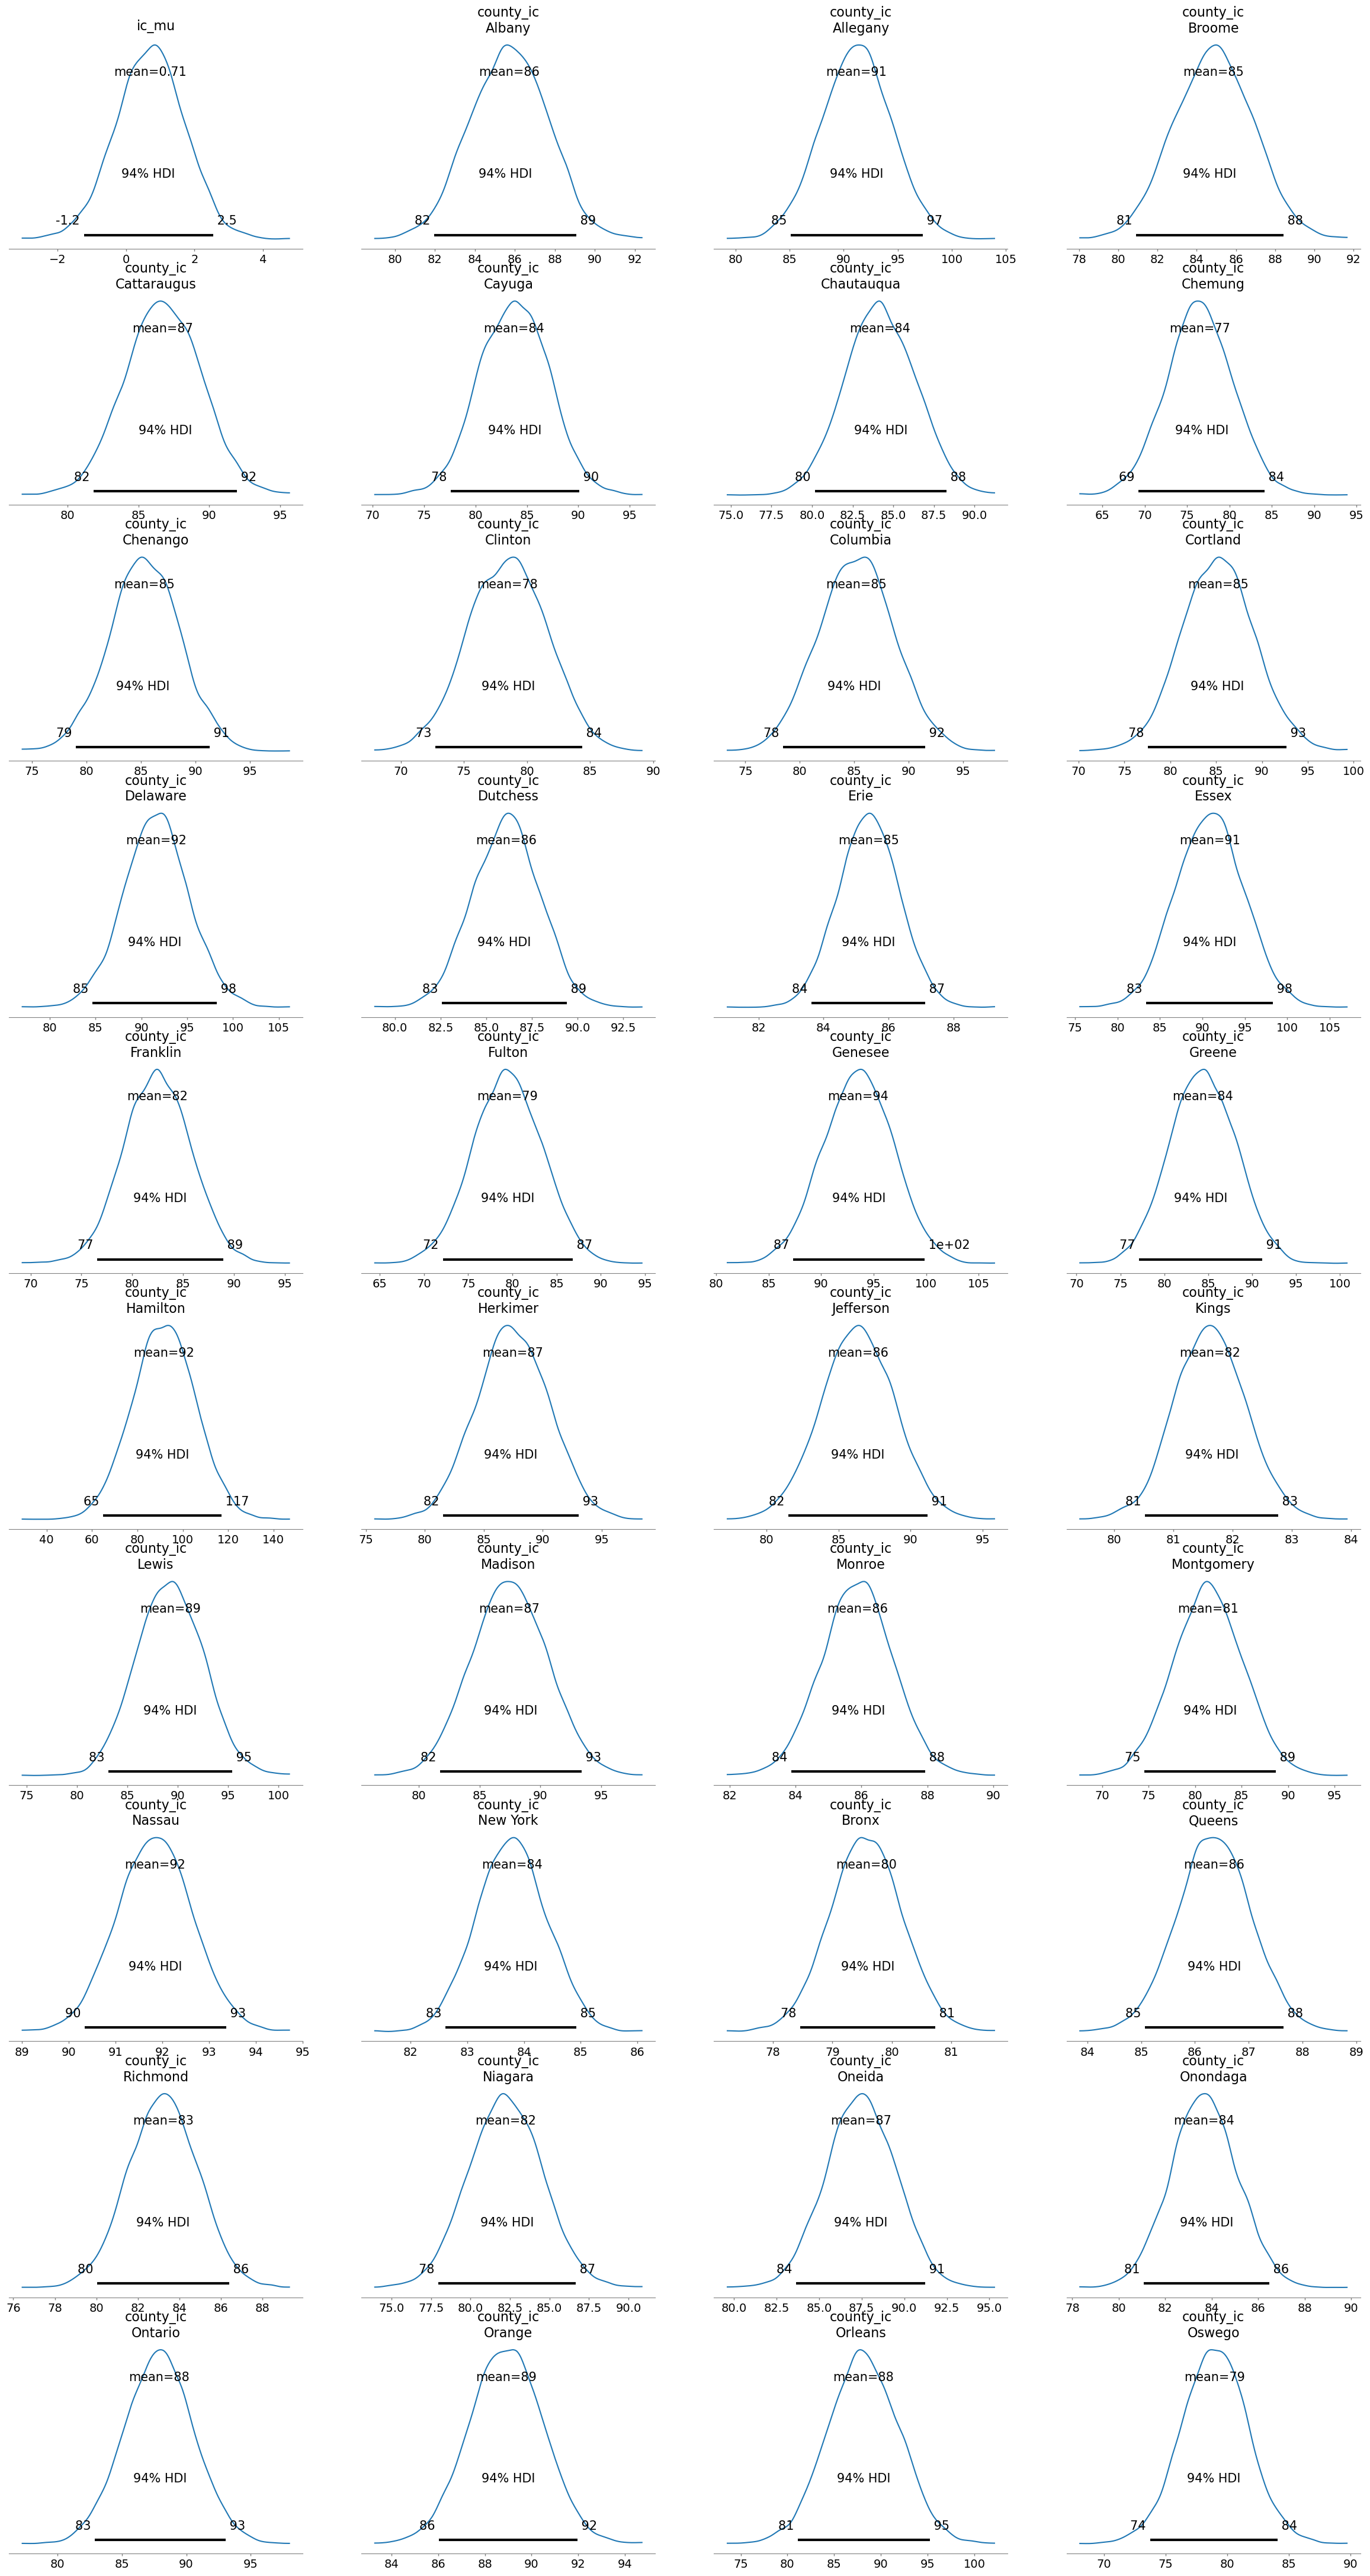

In [146]:
with hierarchical_model:
    az.plot_posterior(hierarchical_trace)

## Scrapwork

In [128]:
coords

{'Hisp_lat': {0, 1},
 'obs_id': array([   0,    1,    2, ..., 4677, 4678, 4679]),
 'County': array(['Albany', 'Allegany', 'Broome', 'Cattaraugus', 'Cayuga',
        'Chautauqua', 'Chemung', 'Chenango', 'Clinton', 'Columbia',
        'Cortland', 'Delaware', 'Dutchess', 'Erie', 'Essex', 'Franklin',
        'Fulton', 'Genesee', 'Greene', 'Hamilton', 'Herkimer', 'Jefferson',
        'Kings', 'Lewis', 'Madison', 'Monroe', 'Montgomery', 'Nassau',
        'New York', 'Bronx', 'Queens', 'Richmond', 'Niagara', 'Oneida',
        'Onondaga', 'Ontario', 'Orange', 'Orleans', 'Oswego', 'Otsego',
        'Putnam', 'Rensselaer', 'Rockland', 'Saint Lawrence', 'Saratoga',
        'Schenectady', 'Schoharie', 'Schuyler', 'Seneca', 'Steuben',
        'Suffolk', 'Sullivan', 'Tioga', 'Tompkins', 'Ulster', 'Warren',
        'Washington', 'Wayne', 'Westchester', 'Wyoming', 'Yates'],
       dtype=object)}

<Axes: xlabel='grad_rate', ylabel='Count'>

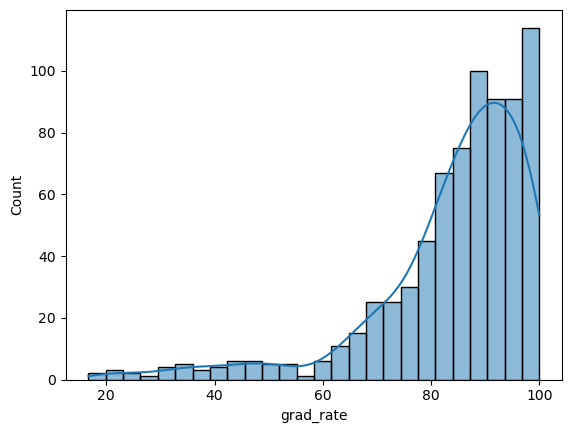

In [123]:
latinx_df = gradrates_df[['Hispanic or Latino','grad_rate']]
latinx_df = latinx_df[latinx_df['Hispanic or Latino']==1]
sns.histplot(latinx_df,x='grad_rate',kde=True)